In [1]:
%load_ext autoreload
%autoreload 2

# Transfer Learning

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/learn/03_transfer_learning.ipynb)

Transfer Learning is a technique that allows us to use a pre-trained model to solve a new problem with better data efficiency. This means that we can obtain better results with less data by leveraging the learned weights of a model that has already been trained on a similar problem. This technique is very useful to train models with small datasets. 

In this notebook we will train a classification model with the EuroSAT dataset, a small dataset of satellite images.

In [3]:
from convnets.datasets import EuroSAT

data = EuroSAT()

data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400


In [4]:
data.train

,image,label
619,data/2750/AnnualCrop/AnnualCrop_2392.jpg,0
16385,data/2750/PermanentCrop/PermanentCrop_446.jpg,6
26137,data/2750/SeaLake/SeaLake_2664.jpg,9
24227,data/2750/SeaLake/SeaLake_1541.jpg,9
18755,data/2750/Residential/Residential_1203.jpg,7
...,...,...
6942,data/2750/HerbaceousVegetation/HerbaceousVeget...,2
10710,data/2750/Highway/Highway_2179.jpg,3
8588,data/2750/HerbaceousVegetation/HerbaceousVeget...,2
15324,data/2750/Pasture/Pasture_1592.jpg,5


In [5]:
from convnets.datasets import ImageClassificationDataset 

dataset = {
    'train': ImageClassificationDataset(data.train.image.values, data.train.label.values),
    'val': ImageClassificationDataset(data.test.image.values, data.test.label.values),
}

len(dataset['train']), len(dataset['val'])

(21600, 5400)

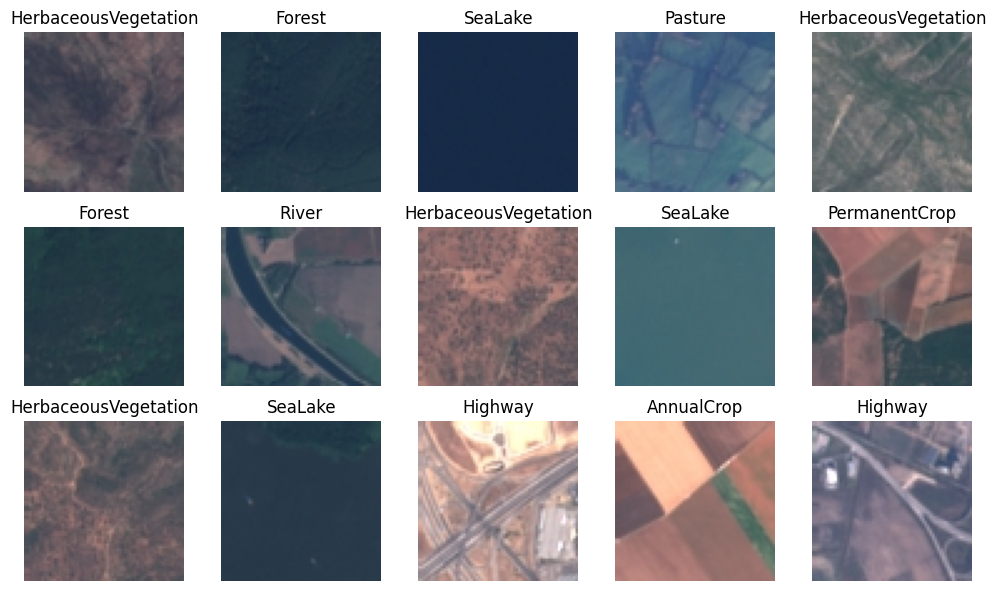

In [6]:
import random
import matplotlib.pyplot as plt
from einops import rearrange

r, c = 3, 5
plt.figure(figsize=(c*2, r*2))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(rearrange(img, 'c h w -> h w c'))
        plt.axis('off')
        plt.title(data.classes[label])
plt.tight_layout()
plt.show()

## Training from scratch

To showcase the power of transfer learning, lets train first a model from scratch. 

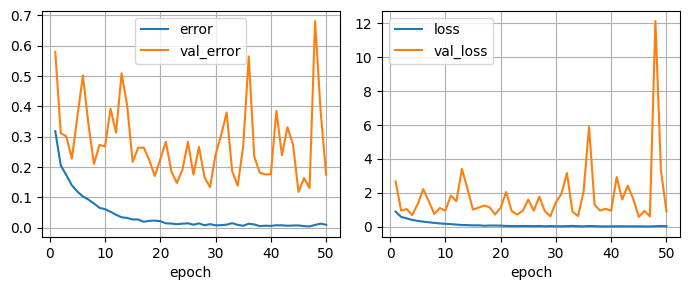

In [11]:
from convnets.train import fit 
import pandas as pd
import torch
from torch.utils.data import DataLoader
from convnets.train import seed_everything
import torchvision

seed_everything()

dataloaders  =  {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = torchvision.models.resnet18(weights=False)
model.fc = torch.nn.Linear(model.fc.in_features, data.num_classes)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=50)

df_scratch = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df_scratch.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df_scratch.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

## Transfer Learning

In transfer learning we use a pre-trained model for feature extraction and train only the last classification layer.

Training model on cuda


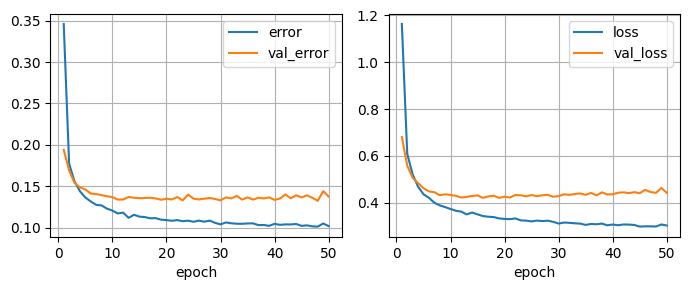

In [12]:
seed_everything()

dataloaders  =  {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# we freeze the weights of the pretrained model so they don't get updated
for param in model.parameters():
	param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, data.num_classes)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=50)

df_transfer = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df_transfer.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df_transfer.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

## Fine-tuning

If our dataset is very different from the one used to train the pre-trained model, and we have enough samples, then we can fine-tune the whole model to obtain better results.

Training model on cuda


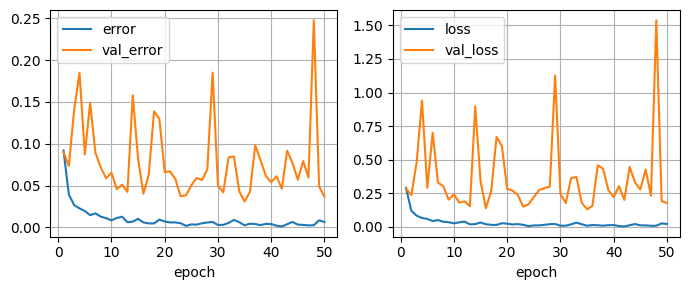

In [15]:
seed_everything()

dataloaders  =  {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

# train all the model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, 10)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=50)

df_ft = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df_ft.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df_ft.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

## Comparing results

For our particular case, fine-tuning gives the best results. We can even go further by pre-training a model in an unsupervised way with lots of similar data (in this case satellite imagery) and then fine-tune it for the final downstream task. This is called self-supervised learning and it is explained in the next notebook.

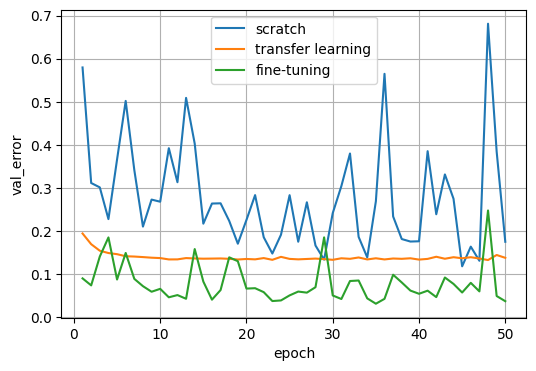

In [21]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(1, 1, 1)
df_scratch.plot(x='epoch', y='val_error', ax = ax, label='scratch')
df_transfer.plot(x='epoch', y='val_error', ax = ax, label='transfer learning')
df_ft.plot(x='epoch', y='val_error', ax = ax, label='fine-tuning')
ax.grid(True)
ax.set_ylabel('val_error')
plt.show()